In [1]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [2]:
print(sklearn.datasets.load_diabetes(scaled=False)["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [3]:
X, y = sklearn.datasets.load_diabetes(as_frame=True, return_X_y=True, scaled=False)

In [4]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0
...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0


##### As we see, sex is the only categorical feature, others are quantitative

In [5]:
X.corrwith(y)

age    0.187889
sex    0.043062
bmi    0.586450
bp     0.441482
s1     0.212022
s2     0.174054
s3    -0.394789
s4     0.430453
s5     0.565883
s6     0.382483
dtype: float64

##### Count mean to unsderstand the scale we work with, count std to know if algorythm is doing better then predicting average.

In [6]:
print(f"Target mean: {y.mean():.3f}\nTarget std:  {y.std():.3f}")

Target mean: 152.133
Target std:  77.093


In [7]:
Xy = X.copy()
Xy["target"] = y

<Figure size 2500x2200 with 0 Axes>

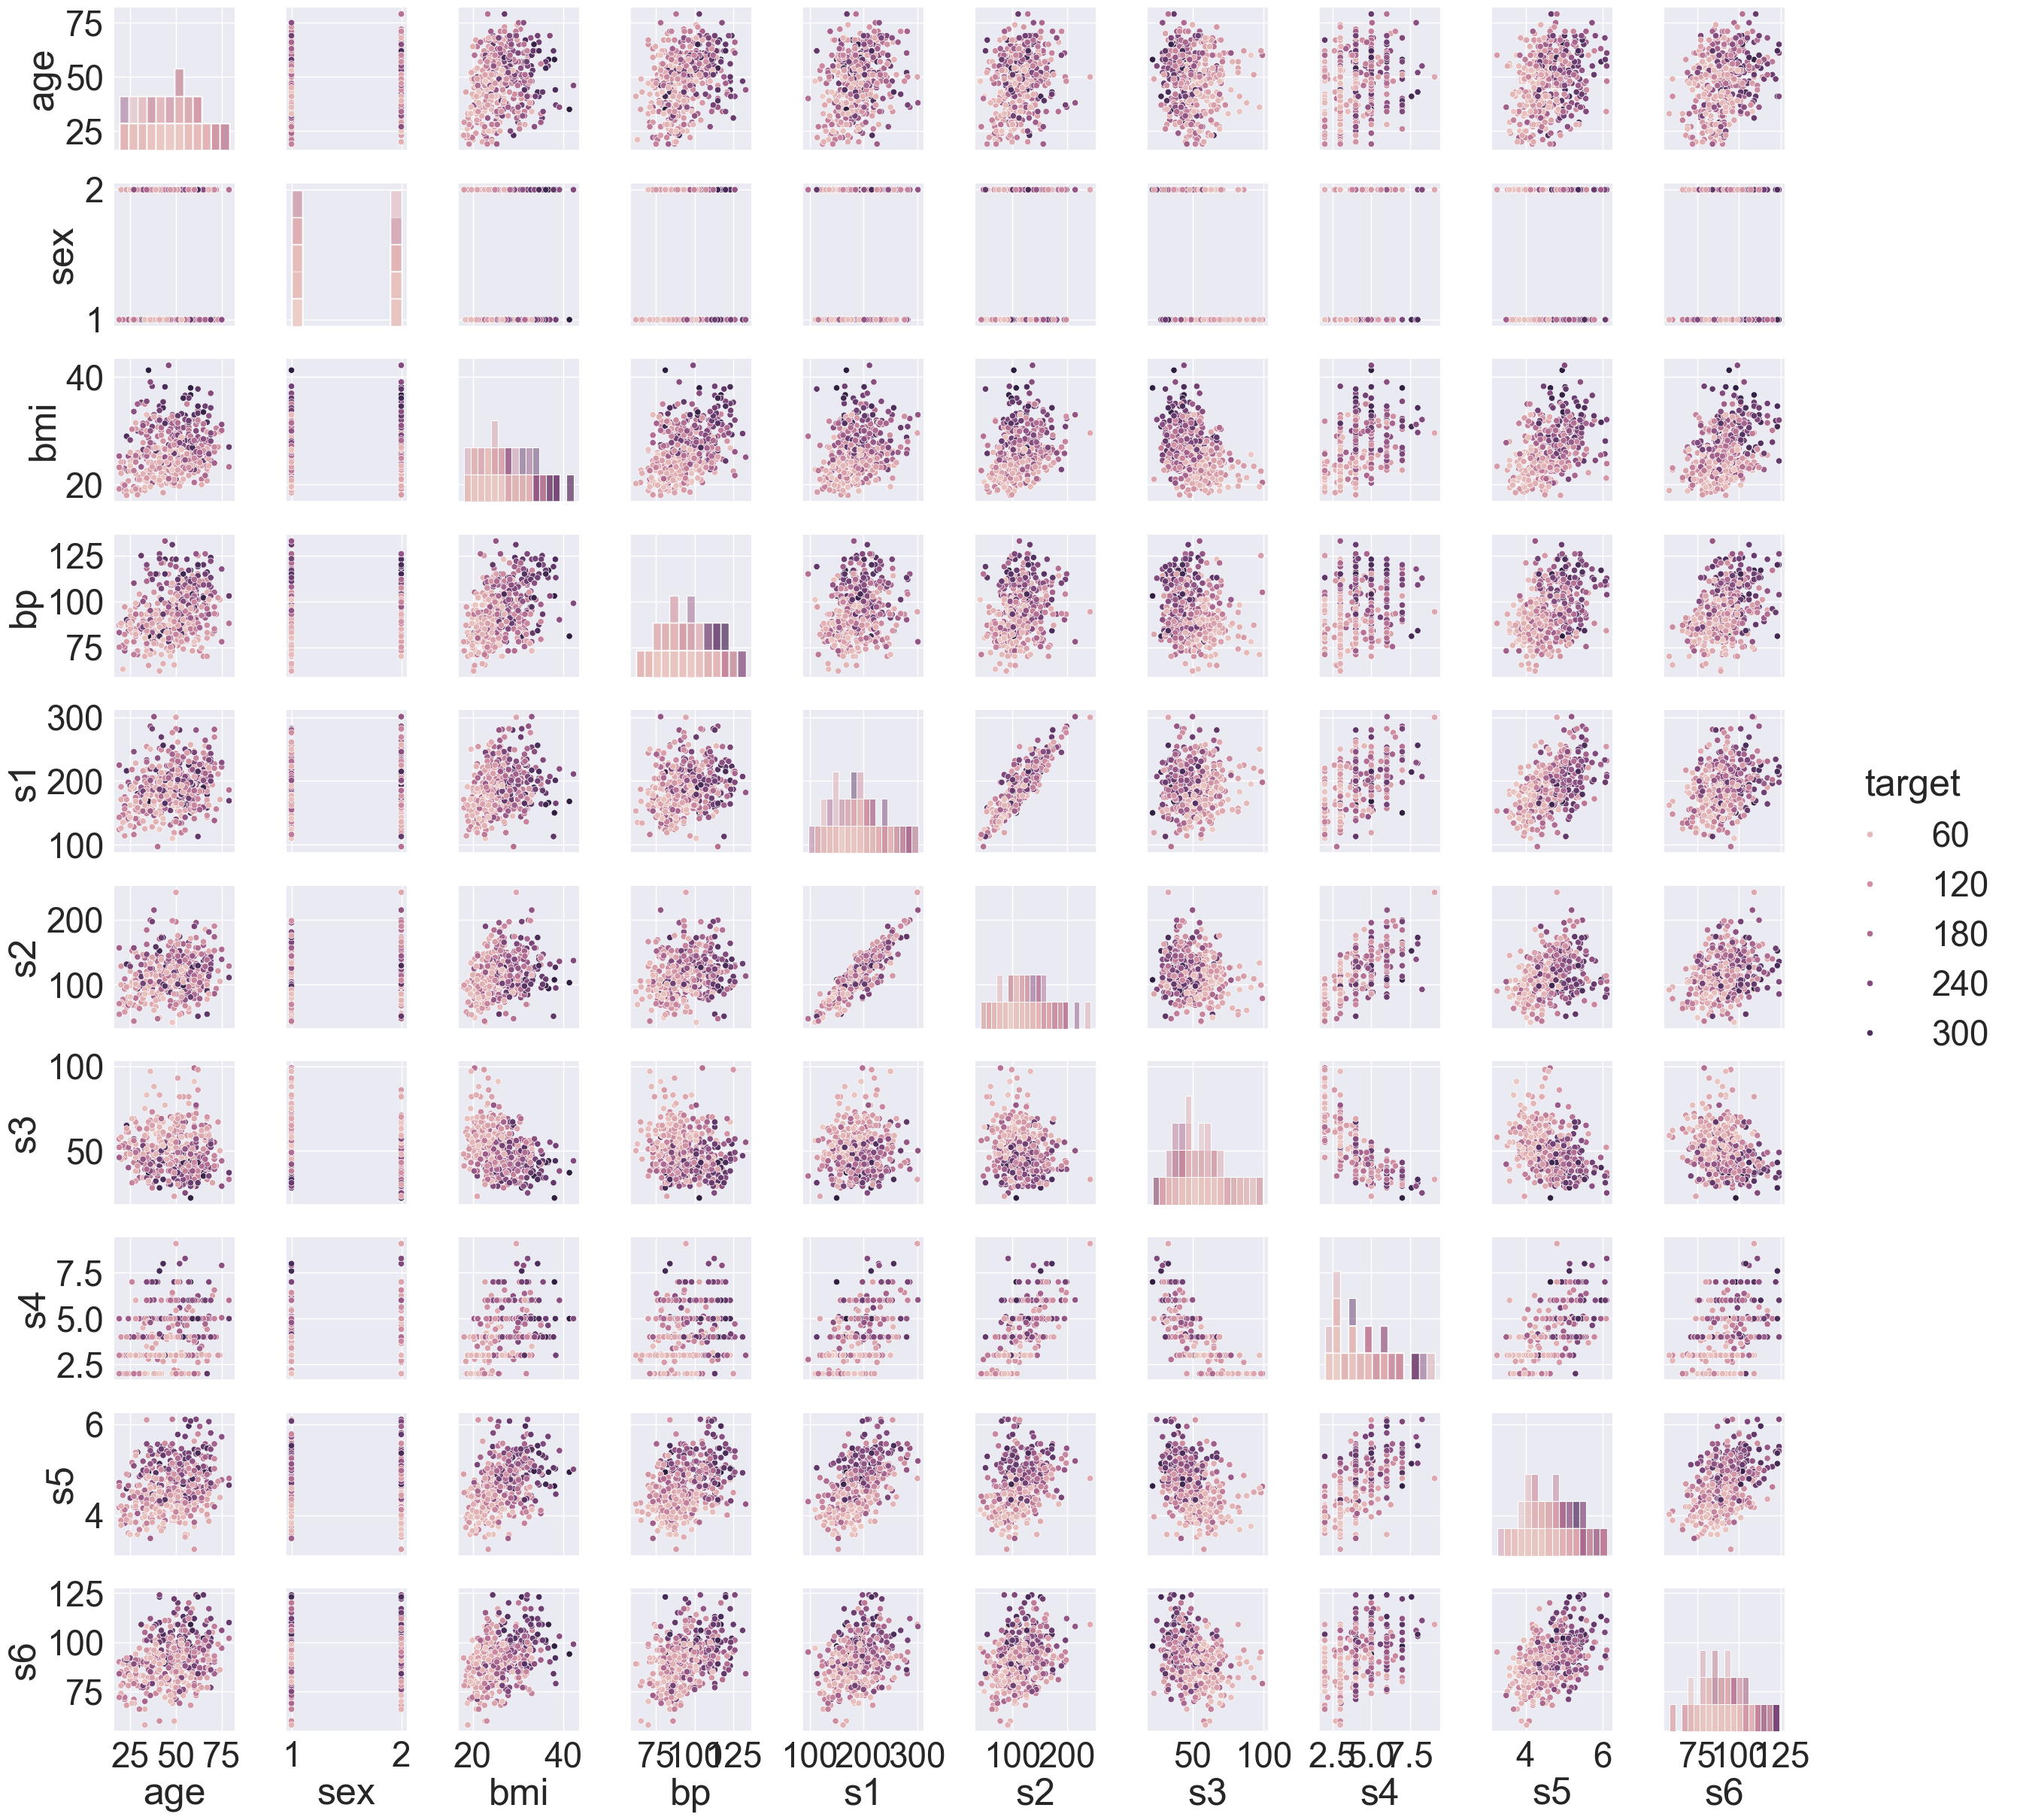

In [8]:
plt.figure(figsize=(25,22))
sns.set(font_scale=3)

sns.pairplot(Xy, hue="target", diag_kind="hist")
plt.show()

##### Seems like there is no dependency between sex and taget, let's build a kde of target for 1 and 2 and check whether it's true and we can remove that feature.

In [9]:
Xy_1 = Xy[Xy.sex == 1]
Xy_2 = Xy[Xy.sex == 2]

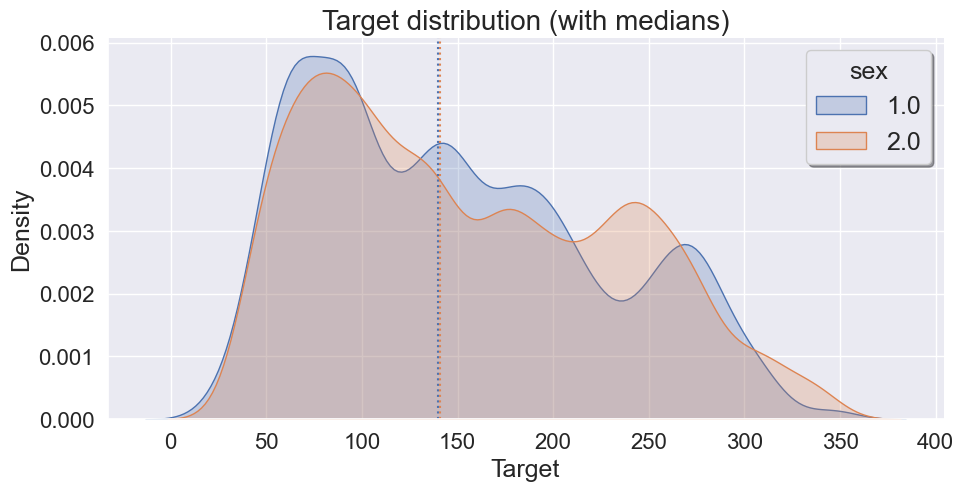

In [10]:
sns.set(font_scale=1.5)
g = sns.FacetGrid(data=Xy[['sex', 'target']], hue='sex', 
                 height=5, aspect=2, legend_out=False)

g.map(sns.kdeplot, 'target', fill=True, bw_adjust=0.5)
g.add_legend(shadow=True, fontsize=18, loc='upper right')
g.ax.axvline(Xy_1.target.median(), ls=':', color=sns.color_palette()[0])
g.ax.axvline(Xy_2.target.median(), ls=':', color=sns.color_palette()[1])

g.ax.set_title('Target distribution (with medians)', fontsize=20)
g.ax.set_xlabel('Target', fontsize=18)
g.ax.set_ylabel('Density', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

##### According to the plot, if there's actually a dependency, it's minor and complex and is unlikely to help linear regression or SVR that's why we just remove that feature for future analysis.

##### Moreover, now we don't need to transform categorical features as this was the only one. (Otherwise sklearn.preprocessing.OneHotEncoder would help)

In [19]:
new_features = ["age", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"]
Xy_train, Xy_test = train_test_split(Xy[new_features+["target"]], test_size=0.15, shuffle=True)

In [20]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Xy_train[new_features])

X_train = Xy_train[new_features] # we won't need scaling for perceptron
y_train = Xy_train["target"]
X_train_scaled = scaler.transform(X_train)

X_test = Xy_test[new_features]
X_test_scaled = scaler.transform(Xy_test[new_features])
y_test = Xy_test["target"]

##### Linear regression

In [43]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error 
from functools import partial
from collections import namedtuple

rmse = partial(mean_squared_error, squared=False)

LR_Params = namedtuple("Params", ["model", "alpha"])
Results = namedtuple("Results", ["train_rmse", "test_rmse"])

# LR_results_dict = {}

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3]
models = [(Ridge, "Ridge"), (Lasso, "Lasso")]


for model, model_name in models:
    for alpha in alphas:

        params=LR_Params(model_name, alpha)
        
        regressor = model(alpha=alpha).fit(X_train_scaled, y_train)
        y_train_pred = regressor.predict(X_train_scaled)
        y_test_pred = regressor.predict(X_test_scaled)

        train_rmse = rmse(y_train, y_train_pred)
        test_rmse = rmse(y_test, y_test_pred)

        res = Results(train_rmse, test_rmse)

        LR_results_dict.update({params: res})
        
[print(f"{key}\nTrain RMSE: {val[0]:.2f}\nTest RMSE: {val[1]:.2f}\n") for key, val in LR_results_dict.items()]

LR_best_params = [key for key, val in LR_results_dict.items() if val[1] == min([v[1] for k, v in LR_results_dict.items()])][0]
print(f"Best params: {LR_best_params}\nBest test RMSE: {LR_results_dict[LR_best_params][1]:.2f}")

Params(model='Ridge', alpha=1e-05)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Ridge', alpha=0.0001)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Ridge', alpha=0.001)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Ridge', alpha=0.01)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Ridge', alpha=0.1)
Train RMSE: 54.55
Test RMSE: 54.35

Params(model='Ridge', alpha=0.5)
Train RMSE: 54.56
Test RMSE: 54.30

Params(model='Ridge', alpha=1)
Train RMSE: 54.56
Test RMSE: 54.26

Params(model='Lasso', alpha=1e-05)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Lasso', alpha=0.0001)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Lasso', alpha=0.001)
Train RMSE: 54.55
Test RMSE: 54.36

Params(model='Lasso', alpha=0.01)
Train RMSE: 54.55
Test RMSE: 54.35

Params(model='Lasso', alpha=0.1)
Train RMSE: 54.59
Test RMSE: 54.27

Params(model='Lasso', alpha=0.5)
Train RMSE: 54.71
Test RMSE: 54.20

Params(model='Lasso', alpha=1)
Train RMSE: 54.76
Test RMSE: 54.17

Params(model='Ridge', 

##### Perceptron

In [22]:
import torch
from torch import nn
from torch.nn import functional as F

n_features = X_train_scaled.shape[-1]

class Perceptron(nn.Module):
    def __init__(self, hidden_size, act_function):
        super().__init__()
        self.linear1 = nn.Linear(n_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.act = act_function
        
    def forward(self, x):
        x = self.act(self.linear1(x))
        x = self.linear2(x)
        return x

In [23]:
from tqdm.auto import tqdm 
from torch.utils.data import TensorDataset, DataLoader
import gc
device = "cuda" if torch.cuda.is_available() else "cpu"


def train(model, train_loader, X_train, y_train, X_test, y_test, criterion, optimizer, n_epochs):
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
        
            y_pred = model(x)
            loss_value = criterion(y_pred, y.unsqueeze(1))

            loss_value.backward()
            optimizer.step()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        
    model.eval()
    with torch.no_grad():
        y_train_pred = model(torch.tensor(X_train, dtype=torch.float).to(device)).detach().cpu().squeeze().numpy()
        y_test_pred = model(torch.tensor(X_test, dtype=torch.float).to(device)).detach().cpu().squeeze().numpy()
        
        train_rmse = rmse(y_train_pred, y_train)
        test_rmse = rmse(y_test_pred, y_test)
        
    return train_rmse, test_rmse

In [41]:
n_epochs = 100 # taking more than enough for such a small dataset, no reason to find best parameter here, as calculation is quite fast

lrs = [1e-3, 1e-2, 5e-2]
hidden_sizes = [10, 50, 100, 200]
weight_decays = [0, 1e-2, 1e-1, 0.5, 1]


act_function = F.tanh
                 
P_Params = namedtuple("Params", ["LR", "Hidden_size", "Weight_decay"])

# P_results_dict = {}

train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float),
                                        torch.tensor(y_train.values, dtype=torch.float)),
                                          batch_size=15, shuffle=True)

for hidden_size in hidden_sizes:
    for lr in lrs:
        for w_d in weight_decays:
            params = P_Params(lr, hidden_size, w_d)
            if P_results_dict.get(params) is None:
                try:
                    del perceptron
                except: pass
                perceptron = Perceptron(hidden_size, act_function).to(device)
                loss = nn.MSELoss()
                optimizer = torch.optim.Adam(perceptron.parameters(), lr=lr, weight_decay=w_d)
    
                train_rmse, test_rmse = train(perceptron, train_loader, X_train_scaled, y_train, 
                                                  X_test_scaled, y_test, loss, optimizer, n_epochs)
                    
                res = Results(train_rmse, test_rmse)
                P_results_dict.update({params: res})
        
[print(f"{key}\nTrain RMSE: {val[0]:.2f}\nTest RMSE: {val[1]:.2f}\n") for key, val in P_results_dict.items()]
P_best_params = [key for key, val in P_results_dict.items() if val[1] == min([v[1] for k, v in P_results_dict.items()])][0]
print(f"Best params: {P_best_params}\nBest test RMSE: {P_results_dict[P_best_params][1]:.2f}")

Params(LR=0.001, Hidden_size=50, Weight_decay=0)
Train RMSE: 82.55
Test RMSE: 78.65

Params(LR=0.001, Hidden_size=50, Weight_decay=0.01)
Train RMSE: 82.36
Test RMSE: 78.58

Params(LR=0.001, Hidden_size=50, Weight_decay=0.1)
Train RMSE: 82.27
Test RMSE: 78.45

Params(LR=0.001, Hidden_size=50, Weight_decay=0.5)
Train RMSE: 82.70
Test RMSE: 78.85

Params(LR=0.001, Hidden_size=50, Weight_decay=1)
Train RMSE: 82.74
Test RMSE: 78.76

Params(LR=0.001, Hidden_size=50, Weight_decay=1.5)
Train RMSE: 82.82
Test RMSE: 78.81

Params(LR=0.01, Hidden_size=50, Weight_decay=0)
Train RMSE: 47.77
Test RMSE: 61.95

Params(LR=0.01, Hidden_size=50, Weight_decay=0.01)
Train RMSE: 48.27
Test RMSE: 61.33

Params(LR=0.01, Hidden_size=50, Weight_decay=0.1)
Train RMSE: 47.64
Test RMSE: 62.00

Params(LR=0.01, Hidden_size=50, Weight_decay=0.5)
Train RMSE: 48.86
Test RMSE: 60.53

Params(LR=0.01, Hidden_size=50, Weight_decay=1)
Train RMSE: 50.29
Test RMSE: 59.74

Params(LR=0.01, Hidden_size=50, Weight_decay=1.5)
Trai

##### LR = 0.05, Hidden_size=200, Weight_Decay=3 seems to be optimal among tested parameters. Don't really want to do more rigorous testing on such simple data and model. Interestingly, it's not any better than linear regression, that takes far less time to compute. Seems that sample size limits the possibilities of even such simple network -- it's overfitting instead of learning necessary dependencies.

##### SVR

In [39]:
rmse = partial(mean_squared_error, squared=False)

SVR_Params = namedtuple("Params", ["kernel", "C", "tol"])
Results = namedtuple("Results", ["train_rmse", "test_rmse"])
SVR_results_dict = {}

kernels = ['linear', 'poly', 'rbf']
Cs = [0.1, 0.3, 0.5, 1, 3, 5, 7, 10]
tols = [1e-8, 1e-5, 1e-4, 1e-3]


for kernel in kernels:
    for C in Cs:
        for tol in tols:
            params=SVR_Params(kernel, C, tol)
            
            regressor = sklearn.svm.SVR(kernel=kernel, C=C, tol=tol, degree=4).fit(X_train_scaled, y_train)
            y_train_pred = regressor.predict(X_train_scaled)
            y_test_pred = regressor.predict(X_test_scaled)
    
            train_rmse = rmse(y_train, y_train_pred)
            test_rmse = rmse(y_test, y_test_pred)
    
            res = Results(train_rmse, test_rmse)
    
            SVR_results_dict.update({params: res})
        
[print(f"{key}\nTrain RMSE: {val[0]:.2f}\nTest RMSE: {val[1]:.2f}\n") for key, val in SVR_results_dict.items()]
SVR_best_params = [key for key, val in SVR_results_dict.items() if val[1] == min([v[1] for k, v in SVR_results_dict.items()])][0]
print(f"Best params: {SVR_best_params}\nBest test RMSE: {SVR_results_dict[SVR_best_params][1]:.2f}")

Params(kernel='linear', C=0.1, tol=1e-08)
Train RMSE: 60.36
Test RMSE: 56.53

Params(kernel='linear', C=0.1, tol=1e-05)
Train RMSE: 60.36
Test RMSE: 56.53

Params(kernel='linear', C=0.1, tol=0.0001)
Train RMSE: 60.36
Test RMSE: 56.53

Params(kernel='linear', C=0.1, tol=0.001)
Train RMSE: 60.36
Test RMSE: 56.53

Params(kernel='linear', C=0.3, tol=1e-08)
Train RMSE: 57.02
Test RMSE: 53.35

Params(kernel='linear', C=0.3, tol=1e-05)
Train RMSE: 57.02
Test RMSE: 53.35

Params(kernel='linear', C=0.3, tol=0.0001)
Train RMSE: 57.02
Test RMSE: 53.35

Params(kernel='linear', C=0.3, tol=0.001)
Train RMSE: 57.02
Test RMSE: 53.35

Params(kernel='linear', C=0.5, tol=1e-08)
Train RMSE: 55.96
Test RMSE: 52.79

Params(kernel='linear', C=0.5, tol=1e-05)
Train RMSE: 55.96
Test RMSE: 52.79

Params(kernel='linear', C=0.5, tol=0.0001)
Train RMSE: 55.96
Test RMSE: 52.79

Params(kernel='linear', C=0.5, tol=0.001)
Train RMSE: 55.96
Test RMSE: 52.79

Params(kernel='linear', C=1, tol=1e-08)
Train RMSE: 54.96
Tes

##### SVR did better than both models above and this is pretty much expected: it generally outperforms linear regression in various tasks, even in that simple ones, and does not overfit as much as neural networks, even such little ones.